In [23]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import deepxde as dde
import scipy as sp
import scipy.interpolate as interp
from deepxde.backend import tf
from matplotlib import pyplot as plt
from numpy.core.shape_base import hstack
exec(compile(open('param.py', "rb").read(), 'param.py', 'exec')) #% Roda arquivo com modelo BCS
def is_float(string):
    """ True if given string is float else False"""
    try:
        return float(string)
    except ValueError:
        return False
def ler_dados(str):
    with open(str, 'r') as f:
        d = f.readlines()
        epocas = np.zeros(len(d));
        tau = np.zeros(len(d));
        j = 0;
        data = []
        for i in d:
            k = i.rstrip().split(" ")
            data.append([float(i) if is_float(i) else i for i in k])
            epocas[j] = float(k[0])
            tau[j] = float(k[1])
            j += 1;
    return tau, epocas

def previsao(modelo,x,t):
    #Plota os três estados em função do tempo desnormalizados juntamente com
    # o valor previsto pela rede
    #modelo a ser recuperado. Requer compilação prévia
    #x = dados reais
    #t = tempo dos dados reais
    x=np.array(x)
    model.restore(modelo,verbose=1)
    yhat = model.predict(t)
    fig3=plt.figure()
    label = ['Pbh (bar)','Pwh (bar)','q(m3/s)'];
    for iu in range(0,3):
        ax3=fig3.add_subplot(3,1,iu+1)
        if iu==2:
            ax3.plot(tempo,((yhat[:,iu])*xc[2]+x0[2])*3600, '-b')
            ax3.plot(tempo,(x[2,:]*xc[2]+x0[2])*3600, ':k')
            #ax3.plot([1,nsim],[umin[iu], umin[iu]],'--r')
            #ax3.plot([1,nsim],[umax[iu], umax[iu]],'--r', label='Restrição')
            ax3.set_ylabel(label[iu])
            #ax3.set(xlim=(xi[0], nsim*ts))
            # if iu==0:
            #     #ax2.set(ylim=(30, 70))
            #     print(iu)
            plt.grid(True)
        elif iu==0:
            ax3.plot(tempo,((yhat[:,iu])*xc[0]+x0[0])/1e5, '-b')
            ax3.plot(tempo,(x[0,:]*xc[0]+x0[0])/1e5, ':k')
            #ax3.plot([1,nsim],[umin[iu], umin[iu]],'--r')
            #ax3.plot([1,nsim],[umax[iu], umax[iu]],'--r', label='Restrição')
            ax3.set_ylabel(label[iu])
            #ax3.set(xlim=(xi[0], nsim*ts))
            # if iu==0:
            #     #ax2.set(ylim=(30, 70))
            #     print(iu)
            plt.grid(True)
        else:
            ax3.plot(tempo,((yhat[:,iu])*xc[1]+x0[1])/1e5, '-b', label='predição')
            ax3.plot(tempo,(x[1,:]*xc[1]+x0[1])/1e5, ':k', label='real')
            #ax3.plot([1,nsim],[umin[iu], umin[iu]],'--r')
            #ax3.plot([1,nsim],[umax[iu], umax[iu]],'--r', label='Restrição')
            ax3.set_ylabel(label[iu])
            #ax3.set(xlim=(xi[0], nsim*ts))
            # if iu==0:
            #     #ax2.set(ylim=(30, 70))
            #     print(iu)
            plt.grid(True)
            ax3.legend();
    plt.show()


# time points
maxtime = 10
time = np.linspace(0, maxtime, 200)

#pbh  pwh q - Pressão de fundo do poço,
#PI índice de produtividade do poço
#PinC  pressão na choke

Dados carregados


In [24]:
fq_ss = 50
zc_ss = 50
pm_ss = 2e6# Pressão de manifold

uss = np.array([[fq_ss], [zc_ss], [pm_ss]])
u = uss
fqref = u[0]
zcref = u[1]
fq = fqref
zc = zcref
fq=60;zc=50;pm=2e6


def constante(valor,time_vector):
    return np.ones_like(time_vector)*valor

def aprbs(valor,time_vector):
    return np.ones_like(time_vector)*valor
# time points
maxtime = 200
time = np.linspace(0, maxtime, 200)
entrada=constante(fq,time)# exogenous input

data = np.load('BCS_data_train_aprbs_f1.npz')
fk=data['fk']
entrada=fk

def ex_func(t):
    spline = sp.interpolate.Rbf(
        time, entrada, function="thin_plate", smooth=0, episilon=0
    )
    # return spline(t[:,0:])
    return spline(t)


In [25]:
# Valores máximos e mínimos para normalização
#Entradas - conforme binder e pavlov
def Lim_c(x):
    return x[1]-x[0]
f_lim=(30,75)
zclim=(0,1)
pmlim=(1e5,50e5)
pbhlim=(1e5,pr) 
pwhlim=(1e5,50e5) 
qlim=(35/3600,65/3600)
pbc=Lim_c(pbhlim)
pwc=Lim_c(pwhlim)
qc=Lim_c(qlim)
pbmin=pbhlim[0]
pwmin=pwhlim[0]
qmin=qlim[0]
H_lim=(-136.31543417849096, 1420.7697113483912)
qch_lim=(0.0, 0.03290348005910621)

rho=tf.Variable(940.0) #PI = 2.32e-9; # Well productivy index [m3/s/Pa]

xc=np.array([pbc,pwc,qc])
x0=np.array([pbmin,pwmin,qmin])

x1=(data['x1']-x0[0])/xc[0]
x2=(data['x2']-x0[1])/xc[1]
x3=(data['x3']-x0[2])/xc[2]
tempo=data['t']
def ED_BCS(t,x):
    ## Montado o sistema de equa��es
    # Tensores (Estados)
    pbh = x[:,0:1]
    pwh = x[:,1:2]
    q = x[:,2:] #Vazão

    # Calculo do HEAD e delta de press�o
    q0 = (q*qc+qmin) / Cq * (f0 / fq)
    H0 = -1.2454e6 * q0 ** 2 + 7.4959e3 * q0 + 9.5970e2
    H = CH * H0 * (fq / f0) ** 2  # Head
    #Pp = rho * g * H  # Delta de press�o
    # Calculo da Potencia e corrente da bomba
    #P0 = -2.3599e9 * q0 ** 3 - 1.8082e7 * q0 ** 2 + 4.3346e6 * q0 + 9.4355e4
    #P = Cp * P0 * (fq / f0) ** 3;  # Potencia
    #I = Inp * P / Pnp  # Corrente

    # Calculo da press�o de intake
    F1 = 0.158 * ((rho * L1 * ((q*qc+qmin)) ** 2) / (D1 * A1 ** 2)) * (mu / (rho * D1 * ((q*qc+qmin)))) ** (1 / 4)
    F2 = 0.158 * ((rho * L2 * ((q*qc+qmin)) ** 2) / (D2 * A2 ** 2)) * (mu / (rho * D2 * ((q*qc+qmin)))) ** (1 / 4)
    #pin = pbh*pbc+pbmin - rho * g * h1 - F1
    # Vazao do reservatorio e vazao na choke
    qr = PI * (pr - (pbh*pbc+pbmin))
    qch = (zc/100)*Cc * tf.sqrt(tf.abs(pwh*pwc+pwmin - pm));

    # Termos não lineares
    #menor q implica em menor F

    F1lim=(435476,440889)
    F2lim=(1.04514e+06,1.05813e+06)
    

    F1c=Lim_c(F1lim)
    F2c=Lim_c(F2lim)
    Hc=Lim_c(H_lim)
    qcc=Lim_c(qch_lim)
    # print('Limites: pbh,pwh,q')
    # print(pbhlim,pwhlim,qlim)
    # print('Limites: F1,F2,H,qch')
    # print(F1lim,F2lim,H_lim,qch_lim)

    #Normalizar termos não lineares
    ##########################
    qch=(qch-qch_lim[0])/qcc
    F1=(F1-F1lim[0])/F1c
    F2=(F2-F2lim[0])/F2c
    H=(H-H_lim[0])/Hc
    ###########################

    # SEDO

    dpbhdt = dde.grad.jacobian(x, t, i=0)
    dpwhdt = dde.grad.jacobian(x, t, i=1)
    dqdt = dde.grad.jacobian(x, t, i=2)

    return [
        dpbhdt - (1/pbc)*b1/V1*(qr - (q*qc+qmin)),
        dpwhdt - (1/pwc)*b2/V2*((q*qc+qmin) - (qcc*qch+qch_lim[0])),
        dqdt - (1/(qc*M))*(pbh*pbc+pbmin - (pwh*pwc+pwmin) - rho*g*hw - (F1c*F1+F1lim[0]) - (F2c*F2+F2lim[0]) + rho * g * (H*Hc+H_lim[0]))
        ]
    
    

In [26]:
def boundary(_, on_initial):
    return on_initial


xss = np.float32(np.array([8311024.82175957,2990109.06207437,0.00995042241351780]))
xssn = (xss-x0)/xc
#print(xssn)


geom = dde.geometry.TimeDomain(0, 200)
#geom = dde.geometry.TimeDomain(0, 1)

ic1 = dde.IC(geom, lambda v: xssn[0], boundary, component=0)
ic2 = dde.IC(geom, lambda v: xssn[1], boundary, component=1)
ic3 = dde.IC(geom, lambda v: xssn[2], boundary, component=2)

tempo=tempo.reshape(len(x1),1)
# print('x1.shape'+str(x1.shape))
# print('x2.shape'+str(x2.shape))
# print('x3.shape'+str(x3.shape))
# print('tempo.shape'+str(tempo.shape))
observe_x1 = dde.PointSetBC(tempo, x1, component=0)
observe_x2 = dde.PointSetBC(tempo, x2, component=1)
observe_x3 = dde.PointSetBC(tempo, x3, component=2)


In [27]:

# data = dde.data.PDE(
#     geom, ED_BCS, [ic1,ic2,ic3],# 35, 1,
#     #geom, ED_BCS, [ic1,ic2,ic3, observe_x1,observe_x2,observe_x3],# 35, 1,
#     #solution=func,
#     #num_test=5
#     num_domain=1,
#     num_boundary=1

#     )
data = dde.data.PDE(
    geom, ED_BCS, [observe_x1,observe_x2,observe_x3],# 35, 1,
    #solution=func,
    num_test=100,
    num_domain=800,
    num_boundary=200,
    anchors=tempo,
    auxiliary_var_function=ex_func
    )
passos=3000
# data = dde.data.PDE(
#         geom, ED_BCS, [ic1,ic2,ic3,ic4,ic5], 35, 2,  num_test=100
#     )
layer_size = [1] + [20]*4 + [3]
activation = "tanh" # 
#activation = "sigmoid"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)
#                   batch_normalization="before")
# callbacks for storing results
fnamevar = "rho.dat"
variable = dde.callbacks.VariableValue(rho, period=50, filename=fnamevar)
model = dde.Model(data, net)
checker = dde.callbacks.ModelCheckpoint(
        "model_norm2/modelo.ckpt", save_better_only=True)
cb=[variable,checker]
#cb=None


Compiling model...
Building feed-forward neural network...
'build' took 0.110322 s

'compile' took 1.159866 s

Initializing variables...
Training model...

0         [1.01e-01, 7.35e-03, 2.61e+01, 4.45e-01, 8.96e-01, 1.70e+00]    [6.91e-02, 6.38e-03, 2.78e+01, 0.00e+00, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model_norm2/modelo.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
1000      [9.73e-03, 9.20e-04, 1.13e-03, 2.74e-02, 1.27e-02, 8.12e-02]    [9.66e-03, 9.33e-04, 1.03e-03, 0.00e+00, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model_norm2/modelo.ckpt-1000 is not in all_model_checkpoint_paths. Manually adding it.
2000      [1.08e-02, 1.03e-03, 1.10e-03, 2.79e-02, 1.26e-02, 7.70e-02]    [1.04e-02, 1.03e-03, 1.11e-03, 0.00e+00, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model_norm2/modelo.ckpt-2000 is not in all_model_checkpoint_paths. Manually adding it.
3000      [9.16e-03, 8.74e-04, 1.00e-03, 2.70e-02, 1.28e-02, 8.27e-02]    [9.74e-03, 9.26e-04, 1.07e-03, 0.00

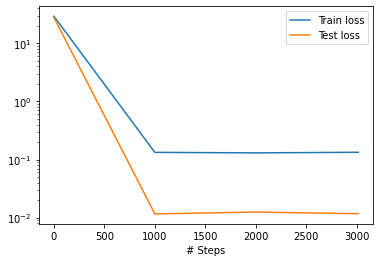

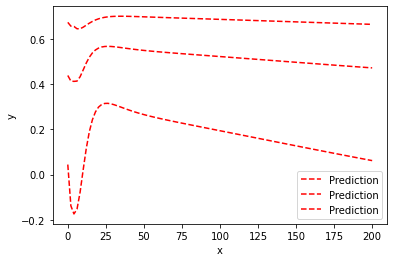

In [28]:
#model.compile("L-BFGS-B")
model.compile("adam", lr=0.01)#, metrics=["l2 relative error"])
model.train(epochs=passos, disregard_previous_best=True, callbacks=cb)
model.compile("L-BFGS-B")
losshistory, train_state =model.train(callbacks=cb)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Restoring model from model_norm2/modelo.ckpt-2000 ...

INFO:tensorflow:Restoring parameters from model_norm2/modelo.ckpt-2000
Predicting...
'predict' took 0.153466 s



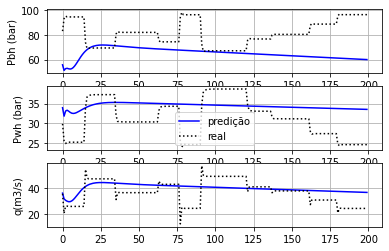

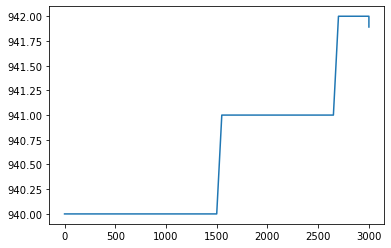

In [29]:
modelo1="model_norm2/modelo.ckpt-"+str(train_state.best_step)
#print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
previsao(modelo1,[x1,x2,x3],tempo)

parametro,epocas=ler_dados("rho.dat")
plt.plot(epocas,parametro)
plt.show()